## A simple model reaching top 6% on Kaggle's "Titanic" competition
The goal of Kaggle's ["Titanic" - competition](https://www.kaggle.com/c/titanic/) is to forecast whether a passenger survives the sinking of the ship, given various data such as age, sex or the number of family members onboard. Although almost overused and overly documented, I wanted to participate in this challenge to practice my scikit-learn skills. This notebook provides a relatively simple SVM model which reaches a top 6% position (~80% correct predictions) on the leaderboard. To do so, I'm combining some of the features extracted by Kaggle user [javiervallejos](https://www.kaggle.com/javiervallejos/) with my own ideas.

We begin by loading and inspecting the dataset. For a complete description of the features given in the data, see https://www.kaggle.com/c/titanic/.

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from numpy.random import seed

seed(2202)

# Load the data from Kaggle
df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(df.columns)
print("")
print(pd.concat((df, test_df)).info())

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB
None


### Imputing the missing data points
While the "Age"-column has many missing data points, the "Name"-column is complete. In addition to the person's name, this column also stores the person's title, which is useful for data imputation. We start by extracting this title.

In [2]:
pd.concat((df,test_df)).isna().sum()
df["Title"] = df["Name"].str.extract('([A-Za-z]+)\.', expand = False)
df["Title"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Ms            1
Sir           1
Jonkheer      1
Capt          1
Countess      1
Don           1
Lady          1
Mme           1
Name: Title, dtype: int64

As a first observation, according to Wikipedia, "Master is an English honorific for boys and young men". The same goes for "Miss". This is also the case in our data set:

<AxesSubplot:ylabel='Frequency'>

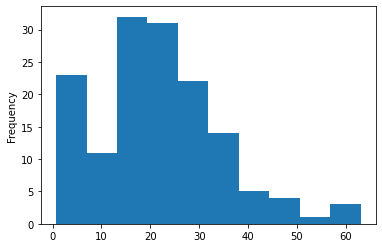

In [3]:
df[df["Title"] == "Miss"]["Age"].plot.hist()

<AxesSubplot:ylabel='Frequency'>

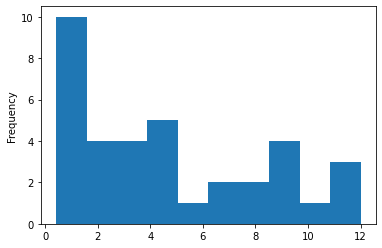

In [4]:
df[df["Title"] == "Master"]["Age"].plot.hist()

Thus, we will fill some of the missing "Age"-data with the mean age of the passengers sharing the same title.

In [5]:
mean_fill = ["Miss","Master","Ms","Dr"]
for title in mean_fill:
    df.loc[(df["Age"].isna()) & (df["Title"] == title),"Age"] = df[df["Title"] == title]["Age"].mean()

It remains to impute the age data for people whose title is either "Mr" or "Mrs". In this case we look at the correlation of the "Age"-column with other features.

In [6]:
print(df[df["Title"] == "Mr"].corr()["Age"])
print("")
print(df[df["Title"] == "Mrs"].corr()["Age"])

PassengerId   -0.016271
Survived       0.023986
Pclass        -0.396574
Age            1.000000
SibSp         -0.115114
Parch          0.051149
Fare           0.113297
Name: Age, dtype: float64

PassengerId    0.142935
Survived      -0.008630
Pclass        -0.256299
Age            1.000000
SibSp         -0.175120
Parch          0.048735
Fare           0.192679
Name: Age, dtype: float64


There is some correlation with the "Pclass"-column, which describes the passenger's ticket class. Thus, we impute by taking the mean value of people sharing the same title and the same class.

In [7]:
for k in range(1,4):
    df.loc[(df["Age"].isna()) & (df["Title"] == "Mr") & (df["Pclass"] == k),"Age"] = df[(df["Pclass"] == k) & (df["Title"] == "Mr")]["Age"].mean()
    df.loc[(df["Age"].isna()) & (df["Title"] == "Mrs") & (df["Pclass"] == k),"Age"] = df[(df["Pclass"] == k) & (df["Title"] == "Mrs")]["Age"].mean()

Next, we note that the "Fare"-column is missing a single item. Since it's also highly correlated with the passenger's ticket class (which does make sense), we will impute using the mean value of ticket costs within the same class.

In [8]:
print(df.corr()["Fare"])
df.loc[df["Fare"].isna(),"Fare"] = df[df["Pclass"] == 3]["Fare"].mean()

PassengerId    0.012658
Survived       0.257307
Pclass        -0.549500
Age            0.110165
SibSp          0.159651
Parch          0.216225
Fare           1.000000
Name: Fare, dtype: float64


Finally, note that the "Ticket"-column does not just store the ticket numbers, but also the location of the cabins. For this simple model, we do not need this extra information.

In [9]:
df["Ticket"].head(5)
df['Ticket'] = df["Ticket"].str.split().apply(lambda x: x[-1])

Converting to a number does not work yet, as some tickets lack a number (the ticket number simply states "LINE"). A quick search yields that those tickets were given out for free to employees of the "American Line". We will set their ticket number to zero.

In [10]:
df.loc[df["Ticket"] == "LINE","Ticket"] = 0
df.Ticket = df["Ticket"].values.astype('int64')

Our model will neither use the "Embarked" nor the "Cabin" data, which is why we won't impute the data for these two columns.

### Feature transformation and extraction
- We transform the passenger's age, sex and the ticket costs to categorical variables.
- We create a new feature called "WoCh" which indicates whether a passenger is either a woman or a child.
- We calculate the family size from the given columns "Parch" and "SibSp", which count the number of parents or children, and the number of siblings or spouses on board, respectively.
- Finally, we create an indicator variable which indicates whether the passenger is part of a family with children or not.

In [11]:
df["AgeBins"] = pd.cut(df["Age"], bins=pd.IntervalIndex.from_tuples([(-1, 15), (15, 35), (35, 50), (50, 120)]))
df["AgeBins"] = df["AgeBins"].cat.codes
df["Sex"] = pd.get_dummies(df["Sex"])["female"]
df["FareBins"] = pd.cut(df["Fare"], bins=pd.IntervalIndex.from_tuples([(-1, 50), (50, 150), (150, 350), (350, 1000)]))
df["FareBins"] = df["FareBins"].cat.codes

woch_titles = ["Miss","Mrs","Master","Mlle","Mme","Ms","Countess","Lady"]
df["WoCh"] = df["Title"].apply(func = lambda x: 1 if x in woch_titles else 0)
df["PartOfFamilyWithChildren"] = df["Parch"].apply(func = lambda x: 1 if x > 0 else 0)
df["FamilySize"] = df["Parch"] + df["SibSp"] + 1

We are now ready to build our model. We use a simple SVM with the radial basis function as kernel. Furthermore, we standardize the ticket class, the ticket number, the family size and the passenger's ID.

In [12]:
# Split the data
X = df.drop(columns="Survived")
y = df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

# Create the pipeline
features = ["Pclass","Sex","AgeBins","PartOfFamilyWithChildren","Ticket","FareBins","FamilySize","PassengerId"]

pipe = Pipeline(steps = [("select-features", ColumnTransformer(transformers=[("select-features", "passthrough", features)])),
                         ("fill-na", SimpleImputer()),
                         ("scaling", ColumnTransformer(transformers=[("scaler", StandardScaler(), [0,4,6,7])], remainder="passthrough")),
                         ("svm", SVC(kernel="rbf"))])
                         
pipe.fit(X_train,y_train)

y_predict = pipe.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test,y_predict)}")

Accuracy score: 0.8324022346368715


For submitting, the code below retrains the model on the entire available data (instead of splitting into a train and a test set) and outputs our predictions.

In [13]:
# The following function performs all of the preprocessing steps introduced above
def preprocess(df):
    df["Title"] = df["Name"].str.extract('([A-Za-z]+)\.', expand = False)
    
    mean_fill = ["Miss","Master","Ms","Dr"]
    for title in mean_fill:
        df.loc[(df["Age"].isna()) & (df["Title"] == title),"Age"] = df[df["Title"] == title]["Age"].mean()
    
    for k in range(1,4):
        df.loc[(df["Age"].isna()) & (df["Title"] == "Mr") & (df["Pclass"] == k),"Age"] = df[(df["Pclass"] == k) & (df["Title"] == "Mr")]["Age"].mean()
        df.loc[(df["Age"].isna()) & (df["Title"] == "Mrs") & (df["Pclass"] == k),"Age"] = df[(df["Pclass"] == k) & (df["Title"] == "Mrs")]["Age"].mean()

    df.loc[df["Fare"].isna(),"Fare"] = df[df["Pclass"] == 3]["Fare"].mean()
    
    df.loc[df["Ticket"] == "LINE","Ticket"] = 0
    df['Ticket'] = df["Ticket"].str.split().apply(lambda x: x[-1])
    df.Ticket = df["Ticket"].values.astype('int64')
    
    df["AgeBins"] = pd.cut(df["Age"], bins=pd.IntervalIndex.from_tuples([(-1, 15), (15, 35), (35, 50), (50, 120)]))
    df["AgeBins"] = df["AgeBins"].cat.codes
    
    df["Sex"] = pd.get_dummies(df["Sex"])["female"]
    
    df["FareBins"] = pd.cut(df["Fare"], bins=pd.IntervalIndex.from_tuples([(-1, 50), (50, 150), (150, 350), (350, 1000)]))
    df["FareBins"] = df["FareBins"].cat.codes

    woch_titles = ["Miss","Mrs","Master","Mlle","Mme","Ms","Countess","Lady"]
    df["WoCh"] = df["Title"].apply(func = lambda x: 1 if x in woch_titles else 0)
    
    df["PartOfFamilyWithChildren"] = df["Parch"].apply(func = lambda x: 1 if x > 0 else 0)
    
    df["FamilySize"] = df["Parch"] + df["SibSp"] + 1
    
    return df

In [14]:
pipe.fit(X,y) # Fit using the entire data
test_df = preprocess(test_df)
prediction = pd.DataFrame(pipe.predict(test_df))
prediction["PassengerId"] = test_df["PassengerId"]
prediction = prediction.set_index("PassengerId").rename(columns={0:"Survived"})

# The following command stores the output as .csv (does not work within this notebook)
prediction.to_csv("results.csv")